# A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 2: CNN Model Development**  
Aims:  
&nbsp; 1): Generate training and test images  
&nbsp; 2): Construct CNN models (a CNN model by own, Xception, VGG16, VGG19, Resnet, Inception, InceptionResnet)  
&nbsp; 3): Tune the hyperparameters of CNN models (hyperparameter optimization)  

## Import libraries

In [1]:
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,precision_recall_fscore_support
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import  ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import  Xception
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.utils import plot_model
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import sklearn.metrics as metrics
import tensorflow.keras as keras
import tensorflow.keras.callbacks as kcallbacks
import time

## Generate Training and Test Images

In [2]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

train_rootdir = './train_224/'
test_rootdir = './test_224/'

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_rootdir,
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        test_rootdir,
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
num_class = train_generator.num_classes

Found 2076 images belonging to 5 classes.
Found 518 images belonging to 5 classes.


In [3]:
test_labels = []
test_images=[]
for subdir, dirs, files in os.walk(test_rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_labels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))

label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [4]:
# Prepare the output dir
output_dir = 'output/CNN_based/2-output-{}'.format(datetime.datetime.now().strftime('%y%m%d-%H%M%S'))
img_dir = os.path.join(output_dir, 'img')
os.makedirs(img_dir)
# Prepare the log file
log_file = open(os.path.join(output_dir, 'classification_report-{}'.format(datetime.datetime.now().strftime('%y%m%d-%H%M%S'))), 'w+')

In [5]:
def get_prediction(model, test_images=test_images, label=label, batch_size=BATCHSIZE, verbose='auto'):
    predict=[]
    length=len(test_images)
    for i in range(((length-1)//batch_size)+1):
        inputimg=test_images[batch_size*i:batch_size*(i+1)]
        test_batch=[]
        for path in inputimg:
            thisimg=np.array(Image.open(path))/255
            test_batch.append(thisimg)
        # thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        # test_shape=(1,)+thisimg.shape
        # thisimg=thisimg.reshape(test_shape)
        model_batch=model.predict(np.array(test_batch), verbose=verbose) #use master model to process the input image
        #generate result by model 1
        # prob=model_batch[0,np.argmax(model_batch,axis=1)[0]]
        predict_batch=list(np.argmax(model_batch,axis=1))
        predict_batch=[label[con] for con in predict_batch]
        predict.extend(predict_batch)
    return predict

### Define the image plotting functions

In [6]:
#plot the figures
#when extra_data enabled please put this callback before early_stopping in case of any problem
class LossHistory(keras.callbacks.Callback):
    def __init__(self, need_extra_data:bool=True, test_images=test_images, test_labels=test_labels, label=label):
        # Enable the recording of precision, recall, f1-score, prediction time (only epoch-wise)
        self.extra_data = need_extra_data
        if need_extra_data:
            self.test_images = test_images
            self.test_labels = test_labels
            self.label = label
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_accuracy = {'batch':[], 'epoch':[]}
        # need extra data --> reset recording list
        # These matrics only make sense over the entire epoch
        if self.extra_data:
            self.precision = []
            self.recall = []
            self.f1_score = []
            self.predict_time = []
            # Record prediction -> for generating report
            self.prediction = []
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_accuracy['batch'].append(logs.get('val_accuracy'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_accuracy['epoch'].append(logs.get('val_accuracy'))
        # need extra data --> calculate and record
        if self.extra_data:
            # Get prediciton
            temp = self.model.stop_training
            start_time = time.time()
            y_pred = get_prediction(model=self.model, test_images=self.test_images, label=self.label, verbose='auto')
            end_time = time.time()
            self.model.stop_training = temp
            # Calculate extra data
            precision,recall,fscore,_= precision_recall_fscore_support(self.test_labels, y_pred, average='weighted', zero_division=0)
            # Record
            self.precision.append(precision)
            self.recall.append(recall)
            self.f1_score.append(fscore)
            self.predict_time.append((end_time-start_time)/len(y_pred))
            # Save prediction
            self.prediction.append(y_pred)
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_accuracy[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        else:
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()
    def get_best(self, target_type:str='epoch', need_extra_data:bool=True):
        # Get the index of the best record
        max_index = self.accuracy[target_type].index(max(self.accuracy[target_type]))
        # Return the accuracy, loss, val_acc, val_loss of the best record
        temp={
            'accuracy': self.accuracy[target_type][max_index], 
            'loss': self.losses[target_type][max_index], 
            'val_accuracy': self.val_accuracy[target_type][max_index], 
            'val_loss': self.val_loss[target_type][max_index]
            }
        # Add extra data if needed and available
        if self.extra_data and need_extra_data and target_type=='epoch':
            temp['precision']=self.precision[max_index]
            temp['recall']=self.recall[max_index]
            temp['f1-score']=self.f1_score[max_index]
            temp['predict_time_per_image']=self.predict_time[max_index]
        return temp
    def generate_report(self, name:str, img_dir=img_dir, log_file=log_file, epoch='best', figsize=(18,14), log_classification_report:bool=True, save_img:bool=True, print_classifiaction_report:bool=True, display_confusion_matrix:bool=True):
        if not self.extra_data:
            raise Exception('Prediction record unavailable')
        # Get prediction
        if epoch=='best': epoch=self.accuracy['epoch'].index(max(self.accuracy['epoch']))
        elif epoch=='worst': epoch=self.accuracy['epoch'].index(min(self.accuracy['epoch']))
        else: epoch-=1
        y_pred = self.prediction[epoch]
        # Generate classification report
        report_str = classification_report(self.test_labels,y_pred,zero_division=0)
        if log_classification_report and log_file.writable(): log_file.write('******{}******\n'.format(name)+report_str+'\n')
        if print_classifiaction_report: print(report_str)
        # Generate confusion matrix
        cm=confusion_matrix(self.test_labels,y_pred)
        f,ax=plt.subplots(figsize=figsize)
        sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
        ax.set_xticklabels(self.label.values())
        ax.set_yticklabels(self.label.values())
        plt.xlabel("y_pred")
        plt.ylabel("y_true")
        if save_img: plt.savefig(os.path.join(img_dir, '{}.pdf'.format(name)))
        if display_confusion_matrix: plt.show()


In [7]:
history_this = LossHistory(need_extra_data=True)
history_hpo = LossHistory(need_extra_data=False)

### Define the processing time measurement functions

In [8]:
# Measure the running time of model training
class TimeMeasurement(keras.callbacks.Callback):
    def __init__(self):
        self.start_time=None
        self.stop_time=None
    # Start timing when trainning starts
    def on_train_begin(self, logs=None):
        self.start_time=time.time()
        self.stop_time=None
    # Stop timing when trainning ends
    def on_train_end(self, logs=None):
        self.stop_time=time.time()
        if self.start_time is None: print("Time Measuring Failed")
    # Get processing time
    def get_processing_time(self):
        if (self.start_time is None or self.stop_time is None): raise Exception("Wrong Time Measurement")
        else: return self.stop_time-self.start_time

In [9]:
timer = TimeMeasurement()

### Define the output sheet

In [10]:
class output_sheet:
    def __init__(self, columns:list=['accuracy', 'loss', 'val_accuracy', 'val_loss', 'precision', 'recall', 'f1-score', 'hpo_time', 'train_time', 'predict_time_per_image']):
        self.output_df = pd.DataFrame(columns=columns)
        # self.output_index = list()
    def add(self, item:str, **values:dict):
        # self.output_df = self.output_df.append(values, ignore_index=True)
        temp = pd.DataFrame(values, columns=self.output_df.columns.to_list(), index=[item])
        self.output_df = pd.concat([self.output_df, temp], axis=0)
        # self.output_index.append(item)
    # def apply_index(self):
    #     self.output_df.index = self.output_index
    def to_excel(self, path=None):
        if path is None: path=os.path.join(output_dir, '2-result-{}.xlsx'.format(datetime.datetime.now().strftime('%y%m%d-%H%M%S')))
        # self.apply_index()
        self.output_df.to_excel(path)

In [11]:
output = output_sheet(columns=['accuracy', 'loss', 'val_accuracy', 'val_loss', 'precision', 'recall', 'f1-score', 'hpo_time', 'train_time', 'predict_time_per_image'])

# Construct CNN models

### Model 1: a CNN model by own (baseline)

In [12]:
def cnn_by_own(input_shape,num_class,epochs,savepath='./model_own.h5',history=history_this,timer=timer):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )

C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - 31s 796ms/step - loss: 1.2531 - accuracy: 0.6382 - val_loss: 1.0754 - val_accuracy: 0.6757
Epoch 2/20
17/17 [==============================] - 6s 364ms/step - loss: 1.0566 - accuracy: 0.6618 - val_loss: 0.9343 - val_accuracy: 0.6757
Epoch 3/20
17/17 [==============================] - 6s 365ms/step - loss: 0.8759 - accuracy: 0.6975 - val_loss: 0.6582 - val_accuracy: 0.7645
Epoch 4/20
17/17 [==============================] - 6s 366ms/step - loss: 0.6108 - accuracy: 0.7813 - val_loss: 1.6579 - val_accuracy: 0.7606
Epoch 5/20
17/17 [==============================] - 6s 368ms/step - loss: 1.1561 - accuracy: 0.6488 - val_loss: 0.7193 - val_accuracy: 0.7568
Epoch 6/20
17/17 [==============================] - 6s 368ms/step - loss: 0.6619 - accuracy: 0.7770 - val_loss: 0.4715 - val_accuracy: 0.8514
Epoch 7/20
17/17 [==============================] - 6s 367ms/step - loss: 0.4242 - accuracy: 0.8709 - val_loss: 0.3141 - val_accuracy: 0.8842
Epoch

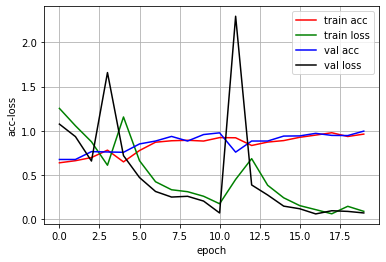

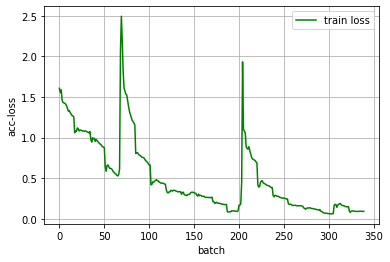

In [13]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=num_class,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')


Validation accuracy of a CNN by own: 99.884%

In [14]:
output.add('model_own', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 2: Xception

In [15]:
def xception( num_class, epochs,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )


C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - 8s 370ms/step - loss: 0.5211 - accuracy: 0.8261 - val_loss: 0.1637 - val_accuracy: 0.9363

Epoch 00001: val_accuracy improved from -inf to 0.93629, saving model to .\xception.h5


C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
17/17 [==============================] - 5s 266ms/step - loss: 0.1200 - accuracy: 0.9624 - val_loss: 0.0670 - val_accuracy: 0.9884

Epoch 00002: val_accuracy improved from 0.93629 to 0.98842, saving model to .\xception.h5


C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/20
17/17 [==============================] - 5s 266ms/step - loss: 0.0637 - accuracy: 0.9865 - val_loss: 0.0373 - val_accuracy: 0.9961

Epoch 00003: val_accuracy improved from 0.98842 to 0.99614, saving model to .\xception.h5


C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/20
17/17 [==============================] - 5s 274ms/step - loss: 0.0375 - accuracy: 0.9957 - val_loss: 0.0297 - val_accuracy: 0.9923

Epoch 00004: val_accuracy did not improve from 0.99614
Epoch 5/20
17/17 [==============================] - 5s 263ms/step - loss: 0.0292 - accuracy: 0.9937 - val_loss: 0.0177 - val_accuracy: 1.0000

Epoch 00005: val_accuracy improved from 0.99614 to 1.00000, saving model to .\xception.h5


C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/20
17/17 [==============================] - 5s 274ms/step - loss: 0.0196 - accuracy: 0.9981 - val_loss: 0.0141 - val_accuracy: 1.0000

Epoch 00006: val_accuracy did not improve from 1.00000
Epoch 7/20
17/17 [==============================] - 5s 286ms/step - loss: 0.0159 - accuracy: 0.9990 - val_loss: 0.0136 - val_accuracy: 1.0000

Epoch 00007: val_accuracy did not improve from 1.00000
Epoch 8/20
17/17 [==============================] - 5s 277ms/step - loss: 0.0142 - accuracy: 0.9986 - val_loss: 0.0092 - val_accuracy: 1.0000

Epoch 00008: val_accuracy did not improve from 1.00000
Epoch 00008: early stopping


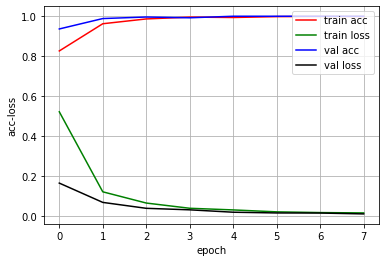

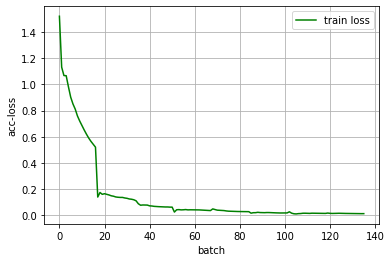

In [16]:
#default only 50, tf36cnn 99
xception(num_class=num_class,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Xception: 100.0%

In [17]:
output.add('Xception', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 3: VGG16

In [18]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )


C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - 6s 296ms/step - loss: 1.3677 - accuracy: 0.6248 - val_loss: 0.4232 - val_accuracy: 0.7645

Epoch 00001: val_accuracy improved from -inf to 0.76448, saving model to .\VGG16.h5
Epoch 2/20
17/17 [==============================] - 5s 269ms/step - loss: 0.3752 - accuracy: 0.8357 - val_loss: 0.2841 - val_accuracy: 0.8514

Epoch 00002: val_accuracy improved from 0.76448 to 0.85135, saving model to .\VGG16.h5
Epoch 3/20
17/17 [==============================] - 5s 278ms/step - loss: 0.2354 - accuracy: 0.9017 - val_loss: 0.1372 - val_accuracy: 0.9421

Epoch 00003: val_accuracy improved from 0.85135 to 0.94208, saving model to .\VGG16.h5
Epoch 4/20
17/17 [==============================] - 5s 269ms/step - loss: 0.1124 - accuracy: 0.9533 - val_loss: 0.0329 - val_accuracy: 0.9903

Epoch 00004: val_accuracy improved from 0.94208 to 0.99035, saving model to .\VGG16.h5
Epoch 5/20
17/17 [==============================] - 5s 271ms/step - loss: 0.0677 - 

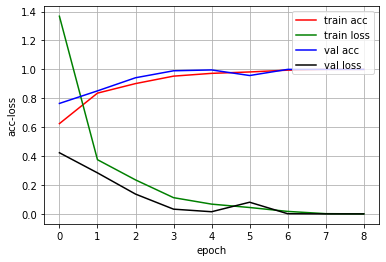

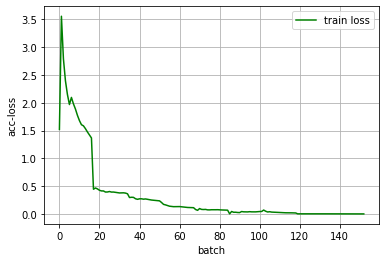

In [19]:
vgg16(num_class=num_class,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG16: 100.0%

In [20]:
output.add('VGG16', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 4: VGG19

In [21]:
def vgg19( num_class, epochs,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )


C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - 5s 293ms/step - loss: 0.7521 - accuracy: 0.7365 - val_loss: 0.1456 - val_accuracy: 0.9846

Epoch 00001: val_accuracy improved from -inf to 0.98456, saving model to .\VGG19.h5
Epoch 2/20
17/17 [==============================] - 5s 275ms/step - loss: 0.0956 - accuracy: 0.9624 - val_loss: 0.0040 - val_accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.98456 to 1.00000, saving model to .\VGG19.h5
Epoch 3/20
17/17 [==============================] - 5s 300ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 1.4397e-04 - val_accuracy: 1.0000

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/20
17/17 [==============================] - 5s 281ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.1747e-04 - val_accuracy: 1.0000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 00004: early stopping


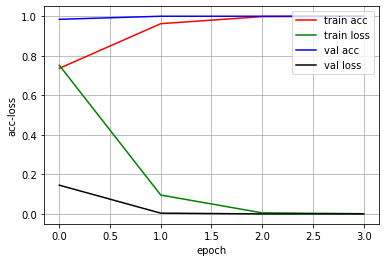

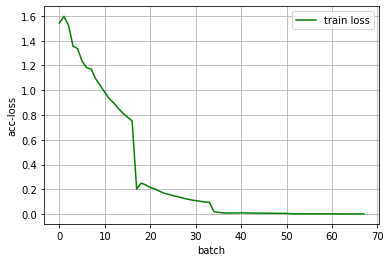

In [22]:
vgg19(num_class=num_class,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG19: 100.0%

In [23]:
output.add('VGG19', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 5: ResNet

In [24]:
def resnet( num_class, epochs,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )

C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - 10s 363ms/step - loss: 0.4972 - accuracy: 0.8194 - val_loss: 92.0054 - val_accuracy: 0.0888

Epoch 00001: val_accuracy improved from -inf to 0.08880, saving model to .\resnet.h5


C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
17/17 [==============================] - 5s 276ms/step - loss: 0.2405 - accuracy: 0.8940 - val_loss: 10.1723 - val_accuracy: 0.7606

Epoch 00002: val_accuracy improved from 0.08880 to 0.76062, saving model to .\resnet.h5


C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/20
17/17 [==============================] - 5s 287ms/step - loss: 0.1374 - accuracy: 0.9369 - val_loss: 5.3267 - val_accuracy: 0.7181

Epoch 00003: val_accuracy did not improve from 0.76062
Epoch 4/20
17/17 [==============================] - 5s 296ms/step - loss: 0.0507 - accuracy: 0.9783 - val_loss: 7.9017 - val_accuracy: 0.7394

Epoch 00004: val_accuracy did not improve from 0.76062
Epoch 00004: early stopping


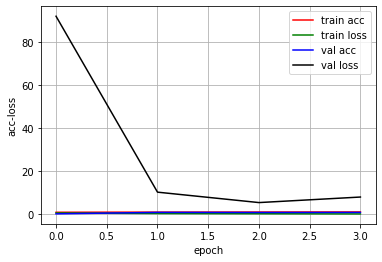

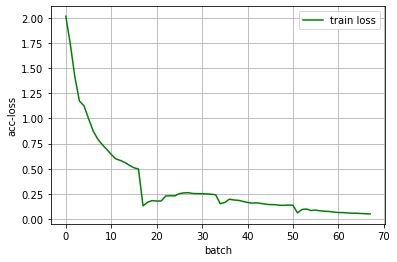

In [25]:
resnet(num_class=num_class,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Resnet: 98.652%

In [26]:
output.add('Resnet', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 6: Inception

In [27]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE, timer=timer):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:35]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[35:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )

C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - 14s 452ms/step - loss: 0.2055 - accuracy: 0.9311 - val_loss: 17.2088 - val_accuracy: 0.6757

Epoch 00001: val_accuracy improved from -inf to 0.67568, saving model to .\inception.h5
Epoch 2/20
17/17 [==============================] - 5s 286ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 2.4793 - val_accuracy: 0.8533

Epoch 00002: val_accuracy improved from 0.67568 to 0.85328, saving model to .\inception.h5
Epoch 3/20
17/17 [==============================] - 5s 294ms/step - loss: 2.5086e-04 - accuracy: 1.0000 - val_loss: 1.7641 - val_accuracy: 0.8764

Epoch 00003: val_accuracy improved from 0.85328 to 0.87645, saving model to .\inception.h5
Epoch 4/20
17/17 [==============================] - 5s 301ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 3.6253 - val_accuracy: 0.7645

Epoch 00004: val_accuracy did not improve from 0.87645
Epoch 5/20
17/17 [==============================] - 5s 300ms/step - loss: 5.9699e-04 - accuracy: 

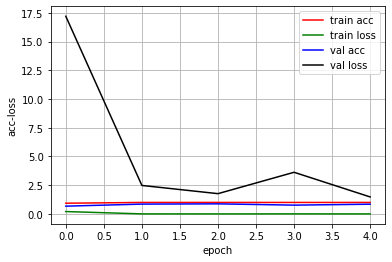

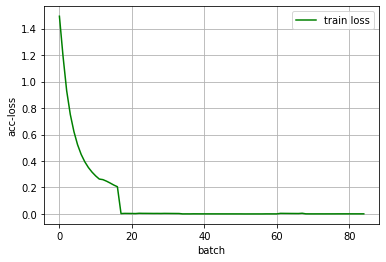

In [28]:
inception(num_class=num_class,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Inception: 100.0%

In [29]:
output.add('Inception', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 7: InceptionResnet

In [30]:
def inceptionresnet( num_class, epochs,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE, timer=timer):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:500]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[500:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )

C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - 17s 525ms/step - loss: 0.3306 - accuracy: 0.8854 - val_loss: 24.5126 - val_accuracy: 0.6757

Epoch 00001: val_accuracy improved from -inf to 0.67568, saving model to .\inceptionresnet.h5
Epoch 2/20
17/17 [==============================] - 6s 337ms/step - loss: 0.0138 - accuracy: 0.9971 - val_loss: 191.9152 - val_accuracy: 0.0039

Epoch 00002: val_accuracy did not improve from 0.67568
Epoch 3/20
17/17 [==============================] - 6s 330ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 91.5789 - val_accuracy: 0.1448

Epoch 00003: val_accuracy did not improve from 0.67568
Epoch 00003: early stopping


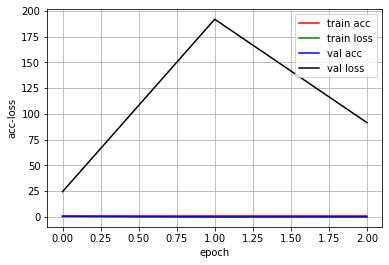

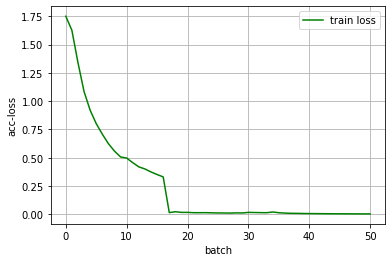

In [31]:
inceptionresnet(num_class=num_class,epochs=20)	# 5-class classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of InceptionResnet: 99.993%

In [32]:
output.add('InceptionResnet', train_time=timer.get_processing_time(), **history_this.get_best())

# Hyperparameter Optimization 
Use VGG16 as an example.  

Tuned hyperparameters of CNN: 
1. The number of frozen layers
2. The number of epochs
3. Early stop patience
4. Learning rate
5. Dropout rate

Hyperparameter optimization methods:
1. Random search
2. Bayesian optimization - Tree Parzen Estimator(BO-TPE)

In [14]:
def prediction(model, test_labels=test_labels, test_images=test_images, label=label):
#read images from validation folder
    # test_labels = []
    # test_images=[]
    # for subdir, dirs, files in os.walk(rootdir):
    #     for file in files:
    #         if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
    #             continue
    #         test_labels.append(subdir.split('/')[-1])
    #         test_images.append(os.path.join(subdir, file))

    # label=validation_generator.class_indices
    # label={v: k for k, v in label.items()}
    # predict=[]
    # length=len(test_images)
    # for i in range(length):
    #     inputimg=test_images[i]
    #     test_batch=[]
    #     thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #     #print(thisimg)
    #     test_shape=(1,)+thisimg.shape
    #     thisimg=thisimg.reshape(test_shape)
    #     model_batch=model.predict(thisimg) #use master model to process the input image
    #     #generate result by model 1
    #     prob=model_batch[0,np.argmax(model_batch,axis=1)[0]]
    #     res=label[np.argmax(model_batch,axis=1)[0]]
    #     predict.append(res)
    acc=accuracy_score(test_labels, get_prediction(model=model, test_images=test_images, label=label))
    return acc

## Model by Own

In [ ]:
def cnn_by_own(num_class,input_shape=INPUT_SIZE,epochs=20,patience=2, dropout_rate=0.5,verbose=0,savepath='./model_own.h5',history=history_this,timer=timer):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=verbose, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[history, timer, earlyStopping, saveBestModel],
        verbose=verbose
    )
    return model

In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = cnn_by_own(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
cnn_by_own(input_shape=INPUT_SIZE, num_class=num_class, verbose=1, **params)

In [ ]:
output.add('model_own (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
cnn_by_own(input_shape=INPUT_SIZE, num_class=num_class, verbose=1, **params)

In [ ]:
output.add('model_own (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## Xception

In [ ]:
def xception( num_class,epochs=20,frozen=15,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        verbose=verbose,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model


In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = xception(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
available_frozen = [50, 100, 131]
space = {
    'frozen': hp.choice('frozen', available_frozen),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': available_frozen[int(best['frozen'])],
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
xception(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('Xception (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
available_frozen = [50, 100, 131]
space = {
    'frozen': hp.choice('frozen', available_frozen),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': available_frozen[int(best['frozen'])],
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
xception(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('Xception (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## VGG16

In [ ]:
def vgg16(num_class,epochs=20,frozen=15,lr=0.001,patience=2, dropout_rate=0.5,verbose=0, savepath='./VGG16.h5',history=history_this,timer=timer,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[history, timer, earlyStopping, saveBestModel],
        verbose = verbose
    )
    return model


In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = vgg16(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
vgg16(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('VGG16 (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
vgg16(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('VGG16 (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## VGG19

In [ ]:
def vgg19( num_class,epochs=20,frozen=15,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        verbose=verbose,
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model


In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = vgg19(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
vgg19(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('VGG19 (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
vgg19(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('VGG19 (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## ResNet

In [ ]:
def resnet( num_class, epochs=20,frozen=120,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        verbose=verbose,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model

In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = resnet(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 50, 150, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
resnet(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('ResNet (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 50, 150, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
resnet(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('ResNet (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## Inception

In [ ]:
def inception( num_class, epochs=20,frozen=120,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE, timer=timer):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        verbose=verbose,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model

In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = inception(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 50, 150, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
inception(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('Inception (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 50, 150, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
inception(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('Inception (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## InceptionResnet

In [ ]:
def inceptionresnet( num_class, epochs=20,frozen=120,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE, timer=timer):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        verbose=verbose,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model

In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = inceptionresnet(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 400, 500, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
inceptionresnet(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('InceptionResnet (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 400, 500, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
inceptionresnet(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('InceptionResnet (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

# Save Result

In [33]:
output.to_excel()

In [ ]:
# # Online GPU renting platform specification
# # WeChat Message
# import requests
# resp = requests.get(
#     "https://www.autodl.com/api/v1/wechat/message/push?token={token}&title={title}&name={name}&content={content}".format(
#         token="",
#         title="From AutoDL",
#         name="UNSW-NB15 CNN",
#         content="Training Complete")
# )
# print(resp.content.decode())
# # Shutdown
# !shutdown